In [16]:
%load_ext watermark
%watermark --python --datename --machine

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.10.0-1034-oem
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [17]:
%matplotlib inline
from tqdm.notebook import tqdm
import tifffile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import isupgrader.data.tiler.v2
import cv2
import os
import math

%watermark --iversion

numpy     : 1.18.0
cv2       : 4.5.3
tifffile  : 2021.7.2
pandas    : 1.3.0
matplotlib: 3.4.2



In [18]:
# Debugging and visualising
IMG_ID = "008308f099f0c565fbc024ece6b8b08c"

# Tiling
LEVEL=1
TILE_SIZE=256
STRIDE=128
N_TILES=36


In [19]:
TRAIN_IMAGES = "/data/raw/panda/train_images/"
df = pd.read_csv("/data/raw/panda/train.csv")

# Change negative gleason_score to 0+0
df["gleason_score"] = df["gleason_score"].apply(lambda x: "0+0" if x == "negative" else x)


In [20]:
def plot_tiles(tiles):
    grid_size = math.ceil(len(tiles)**0.5)

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(16, 16))
    axs = axs.flatten()

    for ax in axs:
        ax.axis("off")

    for tile, ax in zip(tiles, axs):
        ax.axis("on")
        ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.imshow(tile, aspect="auto")

    fig.subplots_adjust(hspace=0, wspace=0)

    plt.show()


In [21]:
%%time

tiff_file = os.path.join(TRAIN_IMAGES, f'{IMG_ID}.tiff')
image = tifffile.imread(tiff_file, key=LEVEL)
image, coords, tiles = isupgrader.data.tiler.v2.generate_tiles(image, TILE_SIZE, STRIDE, N_TILES, only_tiles=False)


CPU times: user 2.3 s, sys: 67.7 ms, total: 2.36 s
Wall time: 2.12 s


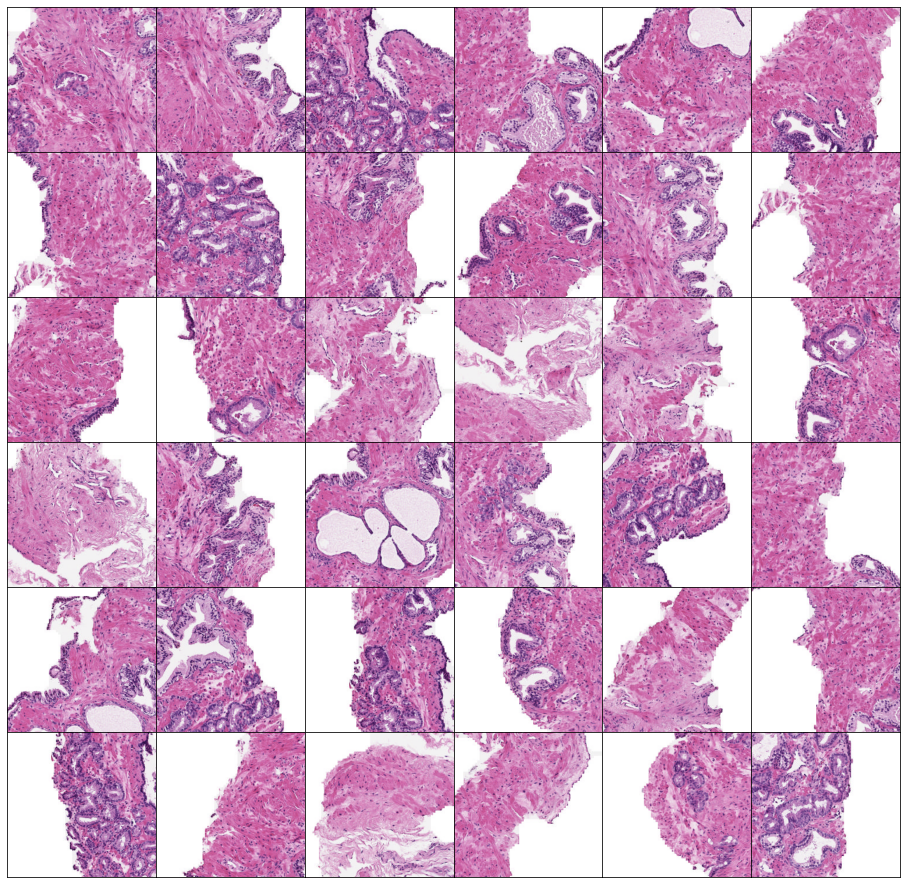

In [22]:
plot_tiles(tiles)

In [23]:
def draw_rectangle_border(img, start, end, border=4, colour=(0, 255, 0)):
    x1 = start[0]
    x2 = end[0]

    y1 = start[1]
    y2 = end[1]

    # top line
    img[x1:x2, y1-border // 2:y1+border//2] = colour
    # bottom line
    img[x1:x2, y2-border//2:y2+border//2] = colour
    # left line
    img[x1-border//2:x1+border//2, y1:y2] = colour
    # right line
    img[x2-border//2:x2+border//2, y1:y2] = colour


In [24]:
def visualise_tiles(image, tiles, coords, resize_factor=0.33):
    tile_size = int(tiles.shape[1] * resize_factor)
    new_shape = (int(image.shape[1] * resize_factor), int(image.shape[0] * resize_factor))

    # resize image and darken image
    image = cv2.resize(image, new_shape, interpolation=cv2.INTER_LANCZOS4) // 3

    for i, (x, y, _, _, _) in enumerate(coords):
        x, y = int(x * resize_factor), int(y * resize_factor)
        image[x: x + tile_size, y: y + tile_size] = cv2.resize(tiles[i],
                                                               (tile_size, tile_size),
                                                               interpolation=cv2.INTER_LANCZOS4)

    for i, (x, y, _, _, _) in enumerate(coords):
        x, y = int(x * resize_factor), int(y * resize_factor)

        colour = (0, 255, 0)
        # Mark tiles that will be excluded as red from inference
        if i + 1 > N_TILES:
            colour = (255, 0, 0)

        draw_rectangle_border(image, (x, y), (x + tile_size, y + tile_size), colour=colour)

    return image

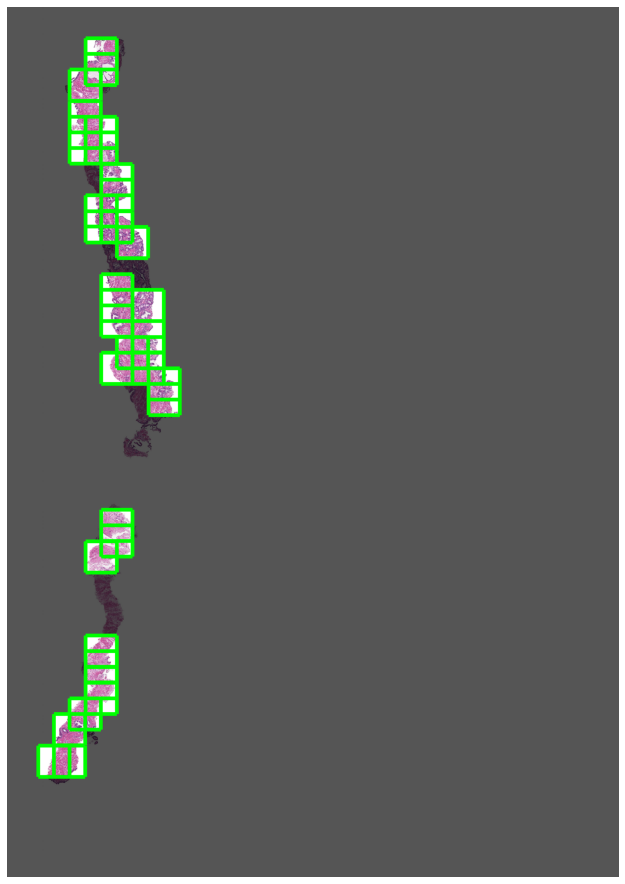

In [25]:
plt.figure(figsize=(16, 16))
plt.imshow(visualise_tiles(image, tiles, coords))

del image, tiles, coords

plt.axis('off')
plt.show()

0it [00:00, ?it/s]

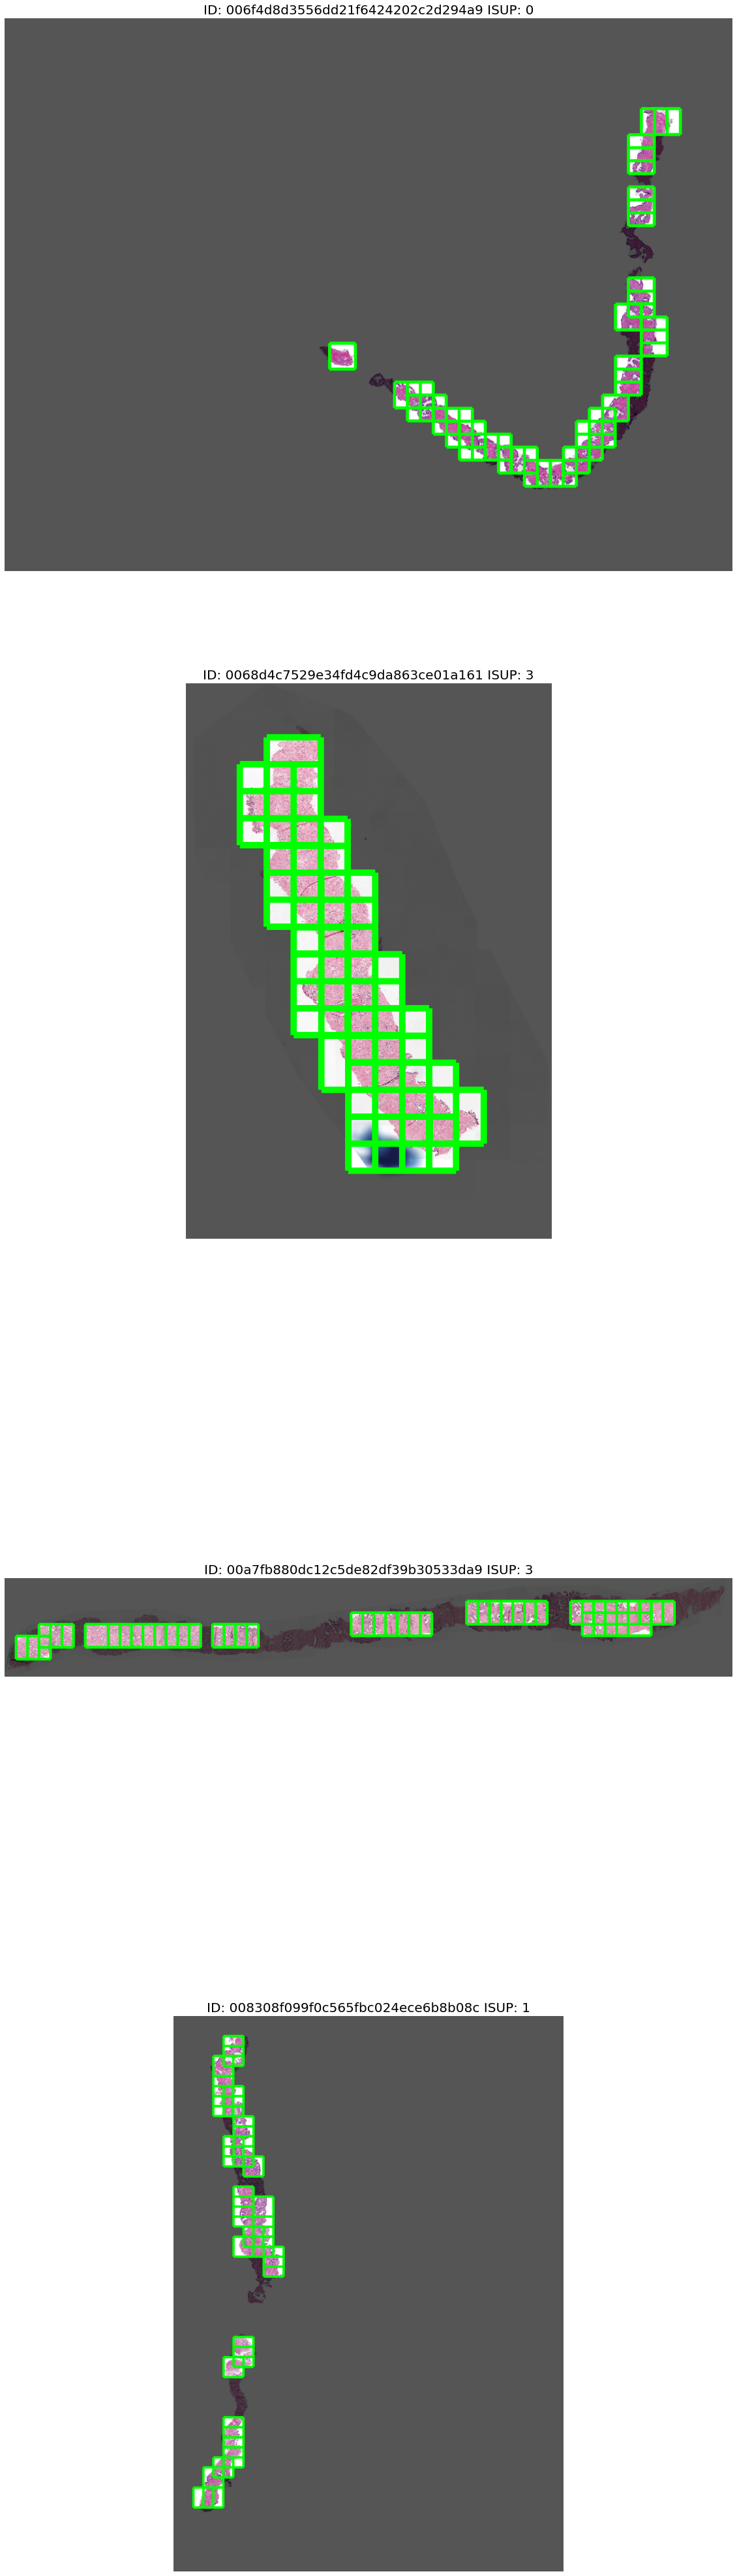

In [26]:
n_slides = 4
sample_slides = df.sample(n_slides).to_numpy()

fig, axs = plt.subplots(n_slides, 1, figsize=(20, 18*n_slides))

for slide, ax in tqdm(zip(sample_slides, axs)):
    image_id = slide[0]
    isup = slide[2]

    tiff_file = os.path.join(TRAIN_IMAGES, f'{image_id}.tiff')
    image = tifffile.imread(tiff_file, key=LEVEL)
    image, coords, tiles = isupgrader.data.tiler.v2.generate_tiles(image, TILE_SIZE, STRIDE, N_TILES, only_tiles=False)

    ax.imshow(visualise_tiles(image, tiles, coords))
    ax.axis('off')
    ax.set_title(f"ID: {image_id} ISUP: {isup}", fontsize=20)